In [1]:
import tensorflow as tf
print("num of GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

num of GPUs: 0


In [2]:
#import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import splitfolders
#import shutil
from keras import initializers
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython import get_ipython
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
#%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/Users/tamima_rashid/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
#splitfolders.ratio('/Users/tamima_rashid/Desktop/Data/Gemep+Beast_Final/', output="/Users/tamima_rashid/Desktop/Data/Gemep+Beast_Final/", seed=1337, ratio=(.75,.15,.10))

In [4]:
# In[6]:


# loading training data
train_datagen = ImageDataGenerator( #rescale to get convert all pixel values 0~1 so that it treats all images with same manner
        rescale=1./255)


# In[13]:


t = (86,86) #resizing all input images 
train_generator = train_datagen.flow_from_directory(
        '/Users/tamima_rashid/Desktop/Data/Data_CNN/Gemep+Beast_Final/train',
        target_size=t,
        batch_size= 42,
        shuffle = True, #shuffling training data to reduce bias and overfitting as the datasets are sorted by class
        class_mode='sparse') #reading class labels as [0,1,2,3,4,5]


# In[14]:



x_train,y_train = train_generator.next() #dividing train generator in x values and y values 


Found 31500 images belonging to 6 classes.


In [5]:
# In[15]:


# loading testing data

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_directory(
        '/Users/tamima_rashid/Desktop/Data/Data_CNN/Gemep+Beast_Final/val',
        target_size=t, 
        shuffle=False,
        batch_size = 42,
        class_mode='sparse')
x_valid,y_valid = valid_generator.next()

Found 6300 images belonging to 6 classes.


In [6]:
# In[38]:


# loading testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/Users/tamima_rashid/Desktop/Data/Data_CNN/Gemep+Beast_Final/test',
        target_size=t,
        batch_size=4200,
        shuffle = False,
        class_mode='sparse')
x_test,y_test = test_generator.next()


Found 4200 images belonging to 6 classes.


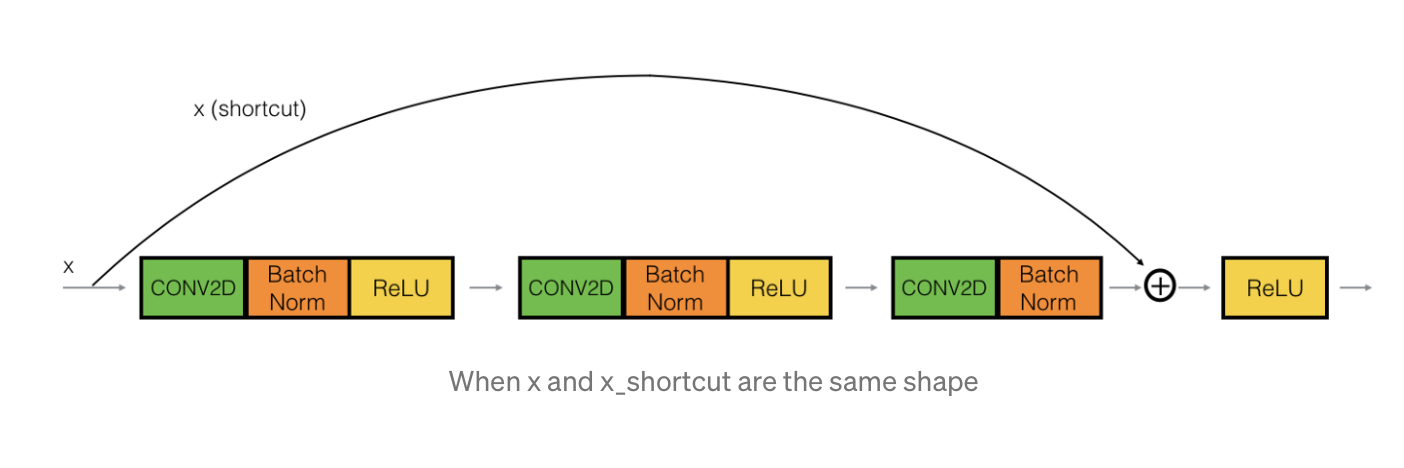

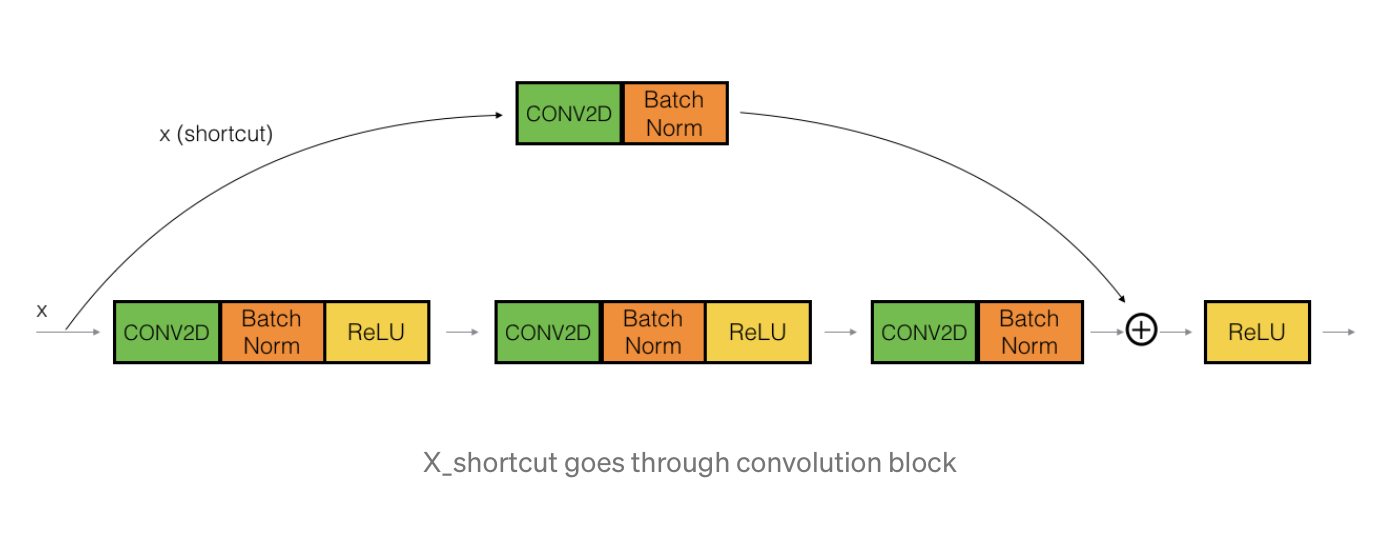

In [7]:
# In[40]:


def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b',kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


# In[41]:


from tensorflow.keras import layers
from tensorflow.keras import initializers

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

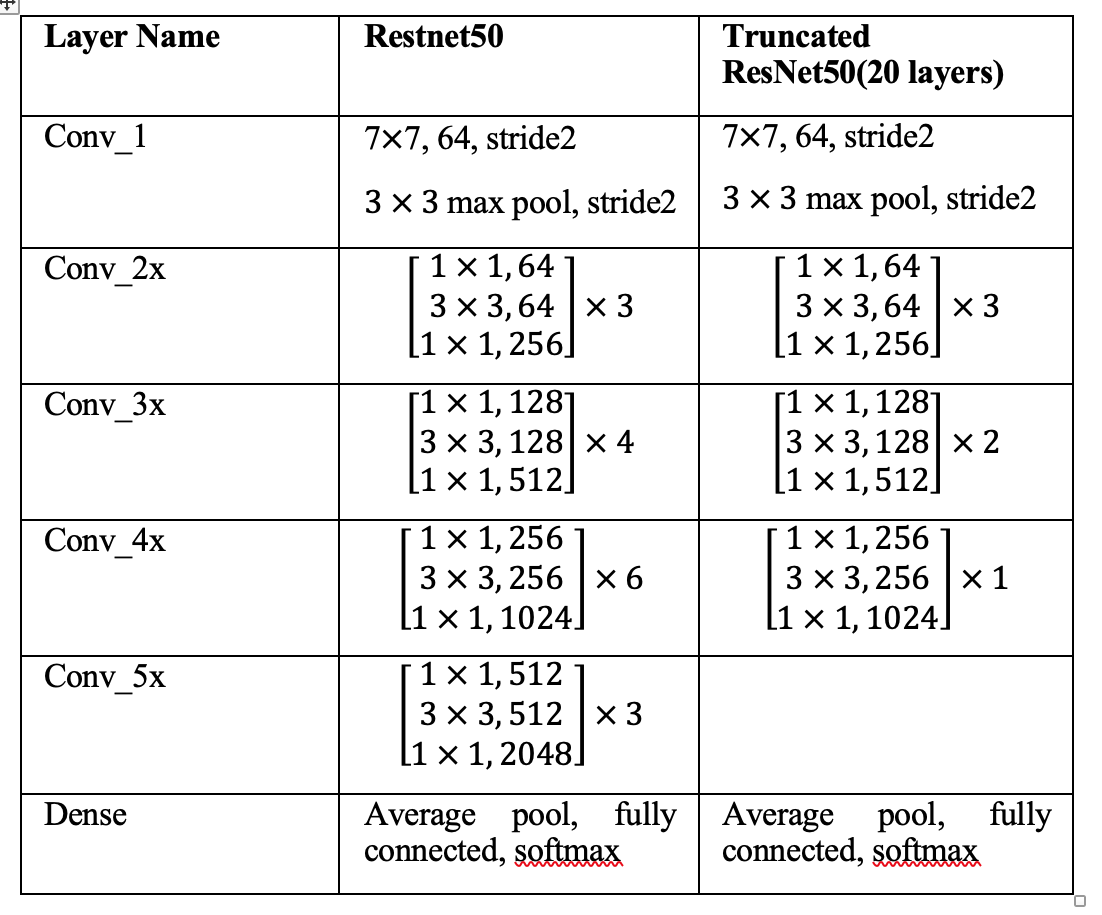

In [8]:
# In[42]:


def ResNet20(input_shape=(86, 86 , 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) # (92,92,3)

    # Stage 1 #1 layer
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer= keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2 #9layers
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines) #6layers
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
   
    # Stage 4 (≈6 lines)# 3 layers
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
  

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)# 1 layer
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [9]:
# In[43]:


model = ResNet20(input_shape = (86, 86, 3), classes = 6)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 86, 86, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 92, 92, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 43, 43, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 43, 43, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
#printing the number of samples and shape
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 42
number of test examples = 4200
X_train shape: (42, 86, 86, 3)
Y_train shape: (42,)
X_test shape: (4200, 86, 86, 3)
Y_test shape: (4200,)


In [12]:
# In[48]:

import time
start = time.time()
history = model.fit(x = train_generator, validation_data= valid_generator, epochs=35, verbose = 2, batch_size = 42)
stop = time.time ()
print(f"Training time: {stop - start}s")

Epoch 1/35
750/750 - 1246s - loss: 1.4607 - accuracy: 0.4848 - val_loss: 0.9341 - val_accuracy: 0.6624
Epoch 2/35
750/750 - 1048s - loss: 0.6881 - accuracy: 0.7432 - val_loss: 0.5994 - val_accuracy: 0.7770
Epoch 3/35
750/750 - 1046s - loss: 0.4399 - accuracy: 0.8400 - val_loss: 0.6651 - val_accuracy: 0.7883
Epoch 4/35
750/750 - 1050s - loss: 0.2990 - accuracy: 0.8936 - val_loss: 0.5411 - val_accuracy: 0.8332
Epoch 5/35
750/750 - 1050s - loss: 0.2238 - accuracy: 0.9209 - val_loss: 0.8326 - val_accuracy: 0.7635
Epoch 6/35
750/750 - 1050s - loss: 0.1743 - accuracy: 0.9381 - val_loss: 0.4309 - val_accuracy: 0.8768
Epoch 7/35
750/750 - 1049s - loss: 0.1471 - accuracy: 0.9477 - val_loss: 0.2785 - val_accuracy: 0.9071
Epoch 8/35
750/750 - 1049s - loss: 0.1190 - accuracy: 0.9575 - val_loss: 0.2467 - val_accuracy: 0.9238
Epoch 9/35
750/750 - 1045s - loss: 0.1015 - accuracy: 0.9646 - val_loss: 0.3025 - val_accuracy: 0.9171
Epoch 10/35
750/750 - 1047s - loss: 0.0985 - accuracy: 0.9661 - val_loss:

In [13]:
# train and test results


train_results = model.evaluate(x_train,y_train, verbose = 2)
test_results = model.evaluate(x_test,y_test, verbose = 2)

2/2 - 1s - loss: 0.0056 - accuracy: 1.0000
132/132 - 30s - loss: 0.1609 - accuracy: 0.9610


In [14]:

from sklearn.metrics import classification_report
y_pred = model.predict(x_test, batch_size=4200) # predicting class of x_test values from test set 


In [16]:
y_pred_bool= np.argmax(y_pred, axis=1)

In [17]:

#classification report
print(classification_report(y_test, y_pred_bool, target_names=["Anger","Disgust","Fear","Happy","Sad","Surprise"]))

              precision    recall  f1-score   support

       Anger       0.96      0.96      0.96       700
     Disgust       0.95      0.97      0.96       700
        Fear       0.98      0.90      0.94       700
       Happy       0.98      0.97      0.98       700
         Sad       0.92      0.98      0.95       700
    Surprise       0.99      0.98      0.98       700

    accuracy                           0.96      4200
   macro avg       0.96      0.96      0.96      4200
weighted avg       0.96      0.96      0.96      4200



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


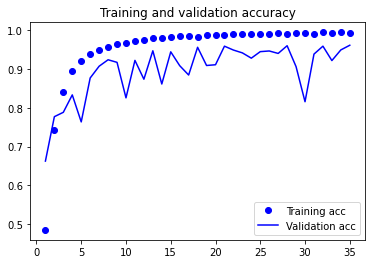

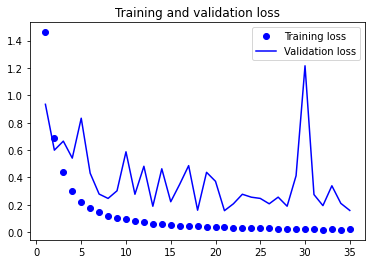

In [18]:

history_dict = history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# In[ ]:

#generatingg training accuracy vs validation accuracy 
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('AC_Final_CNN.png')
plt.figure()
#generatingg training loss vs validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('LC_Final_CNN.png')
plt.show()


# In[60]:

['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
Confusion matrix, without normalization


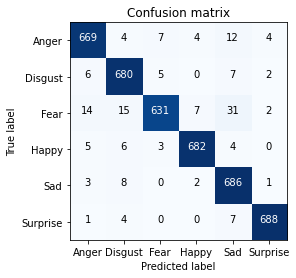

In [19]:
#Confution Matrix 
#Get the accuracy score 
Y_pred = model.predict(test_generator) 
y_pred = np.argmax(Y_pred, axis=1) 
#print('Confusion Matrix')


# In[61]:


target_names = [] 
for key in train_generator.class_indices: 
    target_names.append(key) 
    
print(target_names)


# In[62]:
from sklearn.metrics import classification_report, confusion_matrix 
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues): 
    """ 
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`. 
    """ 
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    #plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes) 
    plt.yticks(tick_marks, classes)

    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        cm = np.around(cm, decimals=2) 
        cm[np.isnan(cm)] = 0.0 
        print("Normalized confusion matrix") 
    else: 
        print('Confusion matrix, without normalization') 
    thresh = cm.max() / 2. 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") 
    #plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
  

#thresh = cm.max() / 2. 
#Matplotlib’s matshow 
cm = confusion_matrix(y_test, y_pred)

plt.figure(3) 
plot_confusion_matrix(cm, target_names, title='Confusion matrix') 
#print(cm) 
#plt.savefig('CM_Final_CNN.png') 
plt.show()


# In[ ]:





# In[ ]:





# In[ ]:

In [20]:
# serialize model to JSON
#Save Model
model_json = model.to_json()
with open("ModelWeightsFinal_CNN_G+I+B.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("ModelWeightsFinal_CNN_G+I+B.h5")
print("Saved model to disk")

Saved model to disk
